In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import binom, multinomial, beta, dirichlet
from scipy.integrate import cumtrapz
import statsmodels.stats.proportion


import pandas as pd

plot_all_lines = False
import warnings
warnings.simplefilter('error', RuntimeWarning)


def beta_std(k, N, alpha=0.32, method='beta'):
    ll, ul = statsmodels.stats.proportion.proportion_confint(k, N, alpha=alpha, method=method)
    return ll, ul, (ul-ll)/2

def pdf_std(P, x, alpha=0.32):
    cdf = cumtrapz(P,x)/cumtrapz(P,x)[-1]
    ll = x[1:][cdf < (0.5-(1-alpha)/2)][-1]
    ul = x[1:][cdf > (0.5+(1-alpha)/2)][0]
    return ll, ul, (ul-ll)/2
    

In [2]:
from scipy.special import binom, loggamma
def logbinom(n, k):
    return loggamma(n+1) - loggamma(k+1) - loggamma(n-k+1)

def logbinom_lnnk(n,k):
    logbinom = k*np.log(n/k - 0.5) + k -0.5*np.log(2*np.pi*k)
    return logbinom
    
def f_b(k, n, p, thresh=100):
    # k is an integer, n is an array
    logf1 = logbinom(n, k)


    logf2 = k*np.log(p)
    logf3 = (n-k)*np.log(1-p)
    logf_b = logf1+logf2+logf3
    return logf_b


def L(Ns, rj, rjp, N_M, Ntot, high_acc=False):
    L = 0
    if high_acc:
        N_Mks = np.linspace(0,N_M,1000)
    else:
        #Ns = Ns.astype(int)
        N_Mks = np.arange(N_M+1)
    for k in range(len(N_Mks)):
        L1 = np.zeros(len(Ns))-np.inf
        L2 = np.zeros(len(Ns))-np.inf
        inds = ((Ns >= k) & (Ntot-Ns >= N_M-k))
        L1[inds] = f_b(k, Ns[inds], rj)
        L2[inds] = f_b(N_M-k, Ntot-Ns[inds], 1-rjp)
        L += np.exp(L1+L2)
    return L

In [3]:
# Total sample size
N = 193
# True merger fraction
f_M = 0.4
# number of classifiers
n = 14
def make_sample(N, f_M, n):
    true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
    f_M_sample = true_gals.sum()/N
    N_true = true_gals.sum()
    
    r_Ms = np.random.uniform(low=0.6, high=0.9, size=n)
    r_Is = np.random.uniform(low=0.6, high=0.9, size=n)

    # Matrix of classifier answers
    m = np.zeros((n, N), dtype='int')
    for i in range(n):
        for j in range(N):
            if true_gals[j] == 0:
                m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
            elif true_gals[j] == 1:
                m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])
    N_M = m.sum(axis=1)

    
    return N_true, N_M, r_Ms, r_Is

n_exp = 1000
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

fs = np.linspace(0,1,1001)
Ns = N*fs
for _ in range(n_exp):
    N_true, N_M, r_Ms, r_Is = make_sample(N, f_M, n)
    lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
    for i in range(n):
        lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
    P = np.exp(lnLi - lnLi.max())
    mu = sum(fs*P)/sum(P)
    ll, ul, sd = pdf_std(P, fs)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    ll, ul, sd = beta_std(sum(N_M), n*N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true

Text(0.5, 0, '$(\\hat f_M-f_M)/\\sigma_{f_M}$')

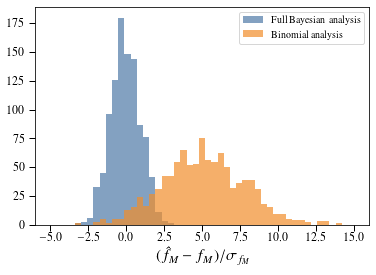

In [8]:
bins = np.linspace(-5,15)
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')

Text(0, 0.5, 'Difference from input sample')

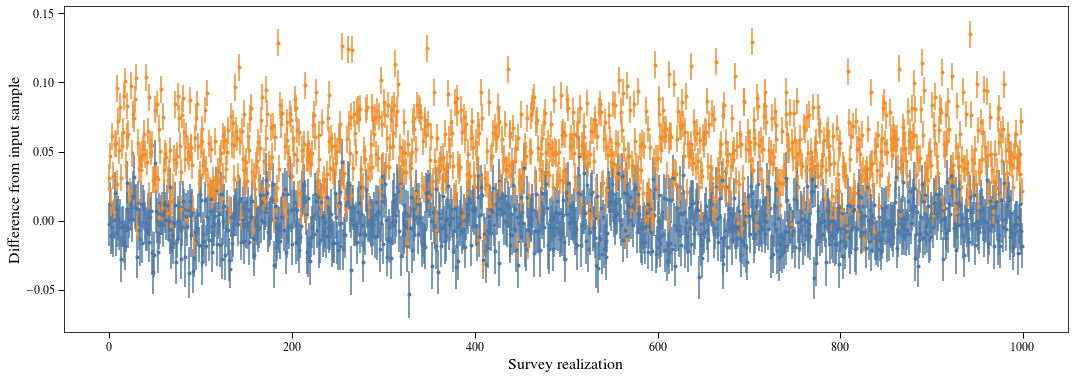

In [11]:
plt.figure(figsize=(18, 6))
inds = np.arange(len(Z1))
plt.errorbar(inds, mu1-N_trues/N, yerr=[mu1-ll1, ul1-mu1], fmt='.')
plt.errorbar(inds, mu2-N_trues/N, yerr=[mu2-ll2, ul2-mu2], fmt='.')
plt.xlabel('Survey realization')
plt.ylabel('Difference from input sample')

Text(0, 0.5, 'Significance of detection')

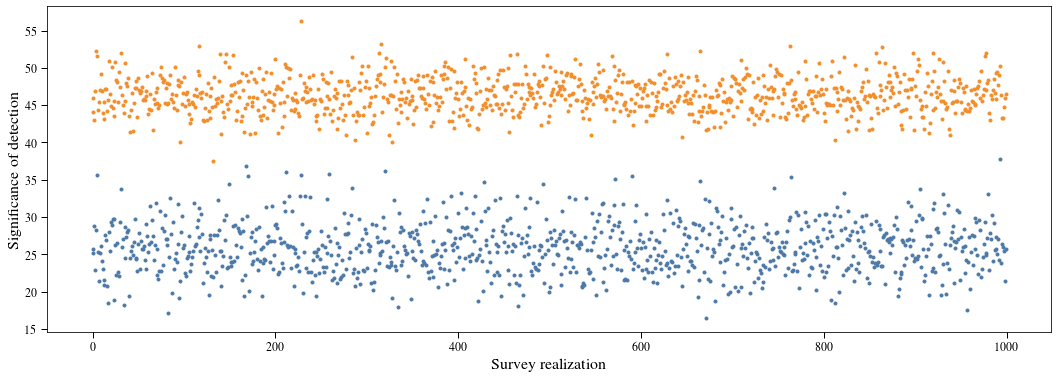

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(inds, mu1/((ul1-ll1)/2), '.')
plt.plot(inds, mu2/((ul2-ll2)/2), '.')
plt.xlabel('Survey realization')
plt.ylabel('Significance of detection')

Text(0, 0.5, 'Significance of difference')

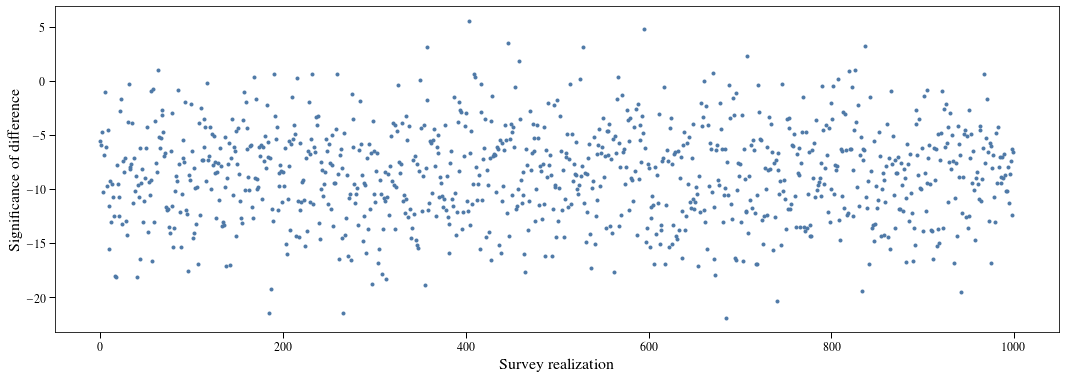

In [13]:
sd1 = ((ul1-ll1)/2)
sd2 = ((ul1-ll1)/2)

sde = np.sqrt(sd1**2/n+sd2**2/n)
t = (mu1-mu2)/sde
plt.figure(figsize=(18, 6))
plt.plot(inds, t, '.')
plt.xlabel('Survey realization')
plt.ylabel('Significance of difference')

In [ ]:
plt.